# Домашнее задание.

Нужно обучить нейронную сеть, точность классификация должна быть не меньше 64%. Как это можно получить:

1. Посмотрите на данные, характеристики.
2. Попробуйте менять гиперпараметры сети.
3. Обратите внимание на саму архитектуру сети.
4. Сделайте подсчет точности на валидационной выборке не через DataLoader.

In [4]:
import os
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim
import torch.utils.data as data_utils

In [5]:
# Fix all seeds

SEED = 42
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [6]:
x_path = os.path.join(os.path.abspath(os.path.join(".", os.pardir)), "data/X_cat.csv")
y_path = os.path.join(os.path.abspath(os.path.join(".", os.pardir)), "data/y_cat.csv")

X = pd.read_csv(x_path, sep = '\t', index_col=0)
target = pd.read_csv(y_path, sep = '\t', index_col=0, names=['status'])

print(X.shape)
X.head()

(26729, 37)


,IsDog,Age,HasName,NameLength,NameFreq,MixColor,ColorFreqAsIs,ColorFreqBase,TabbyColor,MixBreed,...,SexStatus_Flawed,SexStatus_Intact,SexStatus_Unknown,Weekday_0,Weekday_1,Weekday_2,Weekday_3,Weekday_4,Weekday_5,Weekday_6
0,1,365.0,1,7,0.000157,1,0.032919,0.463624,0,1,...,1,0,0,0,0,1,0,0,0,0
1,0,365.0,1,5,0.000655,0,0.008092,0.015005,1,1,...,1,0,0,0,0,0,0,0,0,1
2,1,730.0,1,6,0.000052,1,0.026293,0.357521,0,1,...,1,0,0,0,0,0,0,0,1,0
3,0,21.0,0,7,0.285871,0,0.000471,0.058418,0,1,...,0,1,0,0,0,0,0,1,0,0
4,1,730.0,0,7,0.285871,0,0.023831,0.075353,0,0,...,1,0,0,0,0,0,0,1,0,0


In [34]:
target = target.iloc[:, :]
target[target == 'Died'] = 'Euthanasia'

#### Small preprocessing step

In [35]:
numerical_features = ['Age', 'NameLength', 'NameFreq', 'ColorFreqAsIs', 'ColorFreqBase', 'Hour'] 
not_binary_categorical = ['Year', 'Month', 'Day', ] # To make this categories between 0 and 1 labels

In [36]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score
encoder = LabelEncoder()
scaler = StandardScaler()

y = encoder.fit_transform(target)
X[numerical_features+not_binary_categorical] = scaler.fit_transform(X[numerical_features+not_binary_categorical])

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [37]:
X_train, X_test, y_train, y_test = train_test_split(X.to_numpy(), y, test_size=0.2, stratify = y, random_state = SEED)

#### Creating loaders

In [38]:
BATCH_SIZE = 256
EPOCHES = 50


HIDDEN_SIZE = 25
NUM_CLASSES = 4
INPUT_SIZE = 37

LEARNING_RATE = 1e-3

In [39]:
train_dataset = data_utils.TensorDataset(torch.tensor(X_train.astype(np.float32)), torch.tensor(y_train))
test_dataset = data_utils.TensorDataset(torch.tensor(X_test.astype(np.float32)), torch.tensor(y_test))

train_loader = data_utils.DataLoader(dataset=train_dataset,
                                     batch_size=BATCH_SIZE,
                                     shuffle=True)

test_loader = data_utils.DataLoader(dataset=test_dataset,
                                     batch_size=BATCH_SIZE,
                                     shuffle=False)

loaders = {'train':train_loader, 'test':test_loader}

#### Defining a model

In [40]:
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(SimpleNN, self).__init__()

        self.fc_1 = nn.Linear(in_features=input_size, out_features=hidden_size)
        self.fc_2 = nn.Linear(in_features=hidden_size, out_features=hidden_size)
        self.output = nn.Linear(in_features=hidden_size, out_features=num_classes)
    
    def forward(self, inputs):
        x = self.fc_1(inputs)
        x = F.relu(x)
        x = self.fc_2(x)
        x = F.relu(x)
        x = self.output(x)
        return x

In [51]:
model = SimpleNN(input_size=INPUT_SIZE,
                 hidden_size=HIDDEN_SIZE,
                 num_classes=NUM_CLASSES)

model = model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

#### Training

In [52]:
history = {'train_loss': [], 'test_loss': []}
for epoch in range(EPOCHES):
    train_loss = 0
    test_loss = 0
    test_predict = np.random.rand(NUM_CLASSES)
    for mode, data_loader in loaders.items():
        for X_data, y_data in data_loader:
            X_data, y_data = X_data.to(DEVICE), y_data.to(DEVICE)
            if mode == 'train':
                model.train()
                optimizer.zero_grad()
                output = model(X_data)
                loss = criterion(output, y_data)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
            else:
                model.eval()
                with torch.no_grad():
                    output = model(X_data)
                    loss = criterion(output, y_data)
                    test_loss += loss.item()
                    output = output.cpu()
                    test_predict = np.vstack((test_predict, output))
    
    history['train_loss'].append(train_loss)
    history['test_loss'].append(test_loss)
    test_predict = np.argmax(test_predict, axis=-1)
    test_accuracy = accuracy_score(y_test, test_predict[1:])
    print(f'Epoch: {epoch}, Train loss: {round(train_loss, 4)},\
     Valid loss: {round(test_loss, 4)}, Valid Accuracy: {test_accuracy}')

Epoch: 0, Train loss: 101.2632,     Valid loss: 21.8476, Valid Accuracy: 0.5632248410026188
Epoch: 1, Train loss: 79.6231,     Valid loss: 18.8912, Valid Accuracy: 0.6352413019079686
Epoch: 2, Train loss: 73.3369,     Valid loss: 18.4116, Valid Accuracy: 0.6389824167601945
Epoch: 3, Train loss: 71.916,     Valid loss: 18.2572, Valid Accuracy: 0.644968200523756
Epoch: 4, Train loss: 71.1421,     Valid loss: 18.0446, Valid Accuracy: 0.6462775907220352
Epoch: 5, Train loss: 70.4666,     Valid loss: 17.8762, Valid Accuracy: 0.6537598204264871
Epoch: 6, Train loss: 69.8264,     Valid loss: 17.746, Valid Accuracy: 0.6586232697343809
Epoch: 7, Train loss: 69.329,     Valid loss: 17.721, Valid Accuracy: 0.6612420501309391
Epoch: 8, Train loss: 68.9656,     Valid loss: 17.6071, Valid Accuracy: 0.657500935278713
Epoch: 9, Train loss: 68.5083,     Valid loss: 17.5499, Valid Accuracy: 0.6625514403292181
Epoch: 10, Train loss: 68.352,     Valid loss: 17.4823, Valid Accuracy: 0.6608679386457165
Epoc

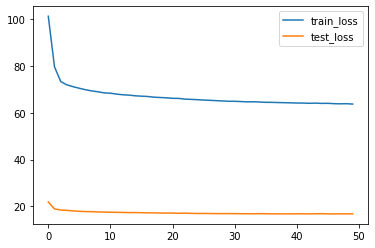

In [56]:
plt.plot(history['train_loss'], label='train_loss')
plt.plot(history['test_loss'], label='test_loss')
plt.legend();

#### Verification of Accuracy without DataLoader

In [49]:
X_verify = torch.Tensor(X_test)
y_verify = torch.LongTensor(y_test)

model.eval()
with torch.no_grad():
    logits = model(X_verify.to(DEVICE))
    predict = torch.argmax(logits, dim=-1)
    accuracy = accuracy_score(y_verify, predict.cpu())
print(f'Received accuracy without DataLoader {accuracy}')

Received accuracy without DataLoader 0.6623643845866068


## GitHub

1. Создайте private репозиторий на GitHub 
2. Сделайте push кода в удаленный репозиторий
3. Добавьте Firyuza и solovyshka в качестве reviewers

Done! =)